## TRAINING IMPLEMENTATION 

In this notebook: 
- training script to be run on GPU

## 1. Imports

In [28]:
import os
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
import scipy
from tqdm import tqdm
import seaborn as sns
import jax

from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
from functools import partial
import math
import csv
import time
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy

from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))
#config.update('jax_debug_nans', True)
from SSN_classes_jax_jit import SSN2DTopoV1_AMPAGABA_ONOFF
from util import GaborFilter, BW_Grating, find_A, create_gratings, param_ratios, create_data

from analysis import findRmax, plot_losses, plot_results

jax backend cpu


->Check GPU available

## 2. PARAMETERS TO DEFINE

### 2.1 Stimuli parameters

In [29]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55
offset = 4

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 0, jitter_val = 5)
stimuli_pars.update(general_pars)

#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    A=None
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

class conn_pars():
    PERIODIC = False
    p_local =  [0.4, 0.7]
    J_2x2 = None
    s_2x2 = None
    sigma_oris = None
        
class filter_pars():
    sigma_g = numpy.array(0.5)
    conv_factor = numpy.array(2)
    k = numpy.array(1.0471975511965976)
    edge_deg = numpy.array( 3.2)
    degree_per_pixel = numpy.array(0.05)
    
class conv_pars:
    dt = 1
    xtol = 1e-05
    Tmax = 1000
    verbose = False
    silent = True
    Rmax_E = None
    Rmax_I= None

class loss_pars:
    lambda_1 = 1
    lambda_2 = 1
    lambda_w = 1
    lambda_b = 1
    
#Initialise network to obtain constant A


In [30]:
# Caleb's params for the full (with local) model:
init_set = 2

if init_set ==1:
    Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
    gE, gI = 0.37328625, 0.26144141
    sigEE, sigIE = 0.2, 0.40
    sigEI, sigII = .09, .09
    conn_pars.p_local = [0.4, 0.7]
    
if init_set==2:
    Js0 = [1.72881688, 1.29887564, 1.48514091, 0.76417991]
    gE, gI = 0.5821754, 0.22660373
    sigEE, sigIE = 0.225, 0.242
    sigEI, sigII = .09, .09
    conn_pars.p_local = [0.0, 0.0]

make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])


signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)
logs_2x2 = np.log(s_2x2)


#Excitatory and inhibitory constants for extra synaptic GABA
c_E = 5.0
c_I = 5.0

#Sigmoid parameters
N_neurons = 25

w_sig = np.asarray([ 4.5694757e-02, -6.1769377e-02, -1.1170033e-01,
                9.6373081e-02, -7.4875370e-02,  1.4620458e-02,
                2.5884593e-01,  2.9179122e-05,  1.0621973e-01,
                2.8737390e-01,  1.6627267e-01,  1.6450347e-01,
                1.8130669e-01,  2.0278645e-01,  3.9605874e-01,
               -6.9331795e-02, -4.5773245e-02,  2.0217678e-01,
                1.0374212e-01, -1.7123434e-01,  1.5612201e-01,
               -2.2408930e-03,  2.6243228e-01,  1.8415983e-01,
                5.3656721e-01])

b_sig = 0.0

sigma_oris = np.asarray([1000.0]) #np.asarray([45.0, 45.0])
ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2, gE = gE, gI=gI, sigma_oris = sigma_oris)
ssn_pars.A=ssn.A

### 2.3 Training params

In [31]:
#Name of results csv
home_dir = os.getcwd()

#Create directory for results
results_dir = os.path.join(home_dir, 'results', 'jitted_function', 'testing_new_training')
if os.path.exists(results_dir) == False:
        os.makedirs(results_dir)
        
        
results_name = 'test_results.csv' #SPECIFY NAME OF RESULTS FILE
if results_name == None:
    results_name = 'results.csv'

results_filename = os.path.join(results_dir, results_name)



In [44]:
#Number of epochs
epochs = 500
num_epochs_to_save =51
epochs_to_save = np.linspace(1 ,epochs, num_epochs_to_save).astype(int)
epochs_to_save = np.insert(epochs_to_save, 0, 0)
noise_type = 'multiplicative'

eta=10e-4
sig_noise = 0
offset = 4
batch_size = 50

## 3. TRAINING!

In [45]:
def save_params_dict(opt_pars, true_acc, ber_acc, epoch ):
    J_2x2, s_2x2 = exponentiate(opt_pars)
     
    save_params= dict(val_accuracy= true_acc, 
                      ber_accuracy = ber_acc,
                J_EE= J_2x2[0,0], J_EI = J_2x2[0,1], 
                              J_IE = J_2x2[1,0], J_II = J_2x2[1,1], 
                s_EE= s_2x2[0,0], s_EI = s_2x2[0,1], 
                              s_IE = s_2x2[1,0], s_II = s_2x2[1,1],
                c_E = opt_pars['c_E'], c_I = opt_pars['c_I'],
                 epoch = epoch, w_sig = opt_pars['w_sig'], b_sig=opt_pars['b_sig'])
    
    return save_params


def exponentiate(opt_pars):
    signs=np.array([[1, -1], [1, -1]]) 
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])

    
    return J_2x2, s_2x2
def create_data(stimuli_pars, number=100, offset = 5, ref_ori=55):
    
    '''
    Create data for given jitter and noise value for testing (not dataloader)
    '''
    data = create_gratings(ref_ori=ref_ori, number=number, offset=offset, **stimuli_pars)
    train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    return train_data


def constant_to_vec(c_E, c_I):
    
    matrix_E = np.zeros((9,9))
    matrix_E = matrix_E.at[2:7, 2:7].set(c_E)
    vec_E = np.ravel(matrix_E)
    
    matrix_I = np.zeros((9,9))
    matrix_I = matrix_I.at[2:7, 2:7].set(c_I)
    vec_I = np.ravel(matrix_I)
    
    constant_vec = np.hstack((vec_E, vec_E, vec_I, vec_I))
    return constant_vec

def our_max(x, beta=0.5):
    #nscipy function
    #max_val = scipy.special.logsumexp(x*beta)/beta
    max_val = np.log(np.sum(np.exp(x*beta)))/beta
    return max_val


def sigmoid(x, epsilon = 0.001):
    '''
    Introduction of epsilon stops asymptote from reaching 1 (avoids NaN)
    '''
    sig = 1/(1+np.exp(x))
    
    return (1 - 2*epsilon)*sig + epsilon


def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def obtain_fixed_point(ssn, ssn_input, conv_pars,  Rmax_E = 50, Rmax_I = 100, inhibition = False):
    
    r_init = np.zeros(ssn_input.shape[0])
    dt = conv_pars.dt
    xtol = conv_pars.xtol
    Tmax = conv_pars.Tmax
    verbose = conv_pars.verbose
    silent = conv_pars.silent
    
    #Find fixed point
    fp, _, avg_dx = ssn.fixed_point_r(ssn_input, r_init=r_init, dt=dt, xtol=xtol, Tmax=Tmax, verbose = verbose, silent=silent)

    avg_dx = np.maximum(0, (avg_dx -1))
    
    #Apply bounding box to data
    r_box = (ssn.apply_bounding_box(fp, size=3.2)).ravel()
    
    #Obtain inhibitory response 
    if inhibition ==True:
        r_box_i = ssn.apply_bounding_box(fp, size=3.2, select='I_ON')
        r_box = [r_box, r_box_i.ravel()]
        
    r_max = np.maximum(0, (our_max(fp[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp[ssn.Ne:-1])/Rmax_I - 1))
    return r_box, r_max, avg_dx

In [46]:
def create_param_1(J_2x2, s_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars):
    
    signs=np.array([[1, -1], [1, -1]])
    logJ_2x2 =np.log(J_2x2*signs)
    logs_2x2 = np.log(s_2x2)
    
    opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)
    conn_pars.sigma_oris = sigma_oris

    return opt_pars, conn_pars

def create_param_2(J_2x2, s_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars):
    
    signs=np.array([[1, -1], [1, -1]])
    logJ_2x2 =np.log(J_2x2*signs)
    
    opt_pars = dict(logJ_2x2 = logJ_2x2, sigm_oris = sigma_oris, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)
    conn_pars.s_2x2 = np.log(s_2x2)

    return opt_pars

def separate_param_1(opt_pars):
    logJ_2x2 = opt_pars['logJ_2x2']
    logs_2x2 = opt_pars['logs_2x2']
    c_E =opt_pars['c_E']
    c_I =opt_pars['c_I']
    w_sig = opt_pars['w_sig']
    b_sig = opt_pars['b_sig']

    
    return logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig


def separate_param_2(opt_pars):
    logJ_2x2 = opt_pars['logJ_2x2']
    c_E =opt_pars['c_E']
    c_I =opt_pars['c_I']
    w_sig = opt_pars['w_sig']
    b_sig = opt_pars['b_sig']
    log_s2x2 = conn_pars.s_2x2
    
    return logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig


def loss(opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, train_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type = 1, readout_pars=None):
    
    if model_type==1:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig = separate_param_1(opt_pars)
    
    if model_type==2:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig = separate_param_2(opt_pars)
    
    total_loss, all_losses , _= vmap_model(logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, ssn_pars, grid_pars, conn_pars, gE, gI, train_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type)
    loss= np.sum(total_loss)
    all_losses = np.mean(all_losses, axis = 0)
    
    return loss, all_losses



def vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type=1, readout_pars=None):
    
    #Separate parameters
    if model_type==1:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig = separate_param_1(opt_pars)
        
    if model_type==2:
        logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig = separate_param_2(opt_pars)
    
    losses, all_losses, pred_labels = vmap_model(logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, ssn_pars, grid_pars, conn_pars, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type)

    #Find accuracy based on predicted labels
    true_accuracy = np.sum(test_data['label'] == pred_labels[0])/len(test_data['label']) 
    ber_accuracy = np.sum(test_data['label'] == pred_labels[1])/len(test_data['label']) 
    
    vmap_loss= np.mean(losses)
    all_losses = np.mean(all_losses, axis = 0)
    
    return vmap_loss, all_losses, true_accuracy, ber_accuracy



def train_SSN_vmap(J_2x2, s_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, ssn_pars, grid_pars, conn_pars, gE, gI, stimuli_pars, filter_pars, conv_pars, loss_pars, epochs_to_save, results_filename = None, batch_size=20, ref_ori = 55, offset = 5, epochs=1, eta=10e-4, sig_noise = None, test_size = 100, noise_type='additive', model_type=1, readout_pars=None):
          
    #Initialize loss
    val_loss_per_epoch = []
    training_losses=[]
    
    #Initialise vmap version of model
    vmap_model = vmap(new_model, in_axes = (None, None, None, None, None, None, None, None, None, None, None, {'ref':0, 'target':0, 'label':0}, None, None, None, None, None) )
    
    if model_type ==1:
        opt_pars, conn_pars = create_param_1(J_2x2, s_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, conn_pars)
    
    #Initialise optimizer
    optimizer = optax.adam(eta)
    opt_state = optimizer.init(opt_pars)
    
    print('Training model with learning rate {}, sig_noise {} at offset {}, lam_w {}, batch size {}, noise_type {}'.format(eta, sig_noise, offset, loss_pars.lambda_w, batch_size, noise_type))
    
    #Define test data - no need to iterate
    test_data = create_data(stimuli_pars, number = test_size, offset = offset, ref_ori = ref_ori)
    val_loss, all_losses, true_acc, ber_acc= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type)
    print('Before training  -- loss: {}, true accuracy: {} , Bernoulli accuracy: {} (learning rate: {})'.format(np.round(float(val_loss), 3), np.round(true_acc, 3), np.round(ber_acc, 3), eta))
    val_loss_per_epoch.append(val_loss)
    
    #Save initial parameters
    save_params = save_params_dict(opt_pars=opt_pars, true_acc=true_acc, ber_acc = ber_acc, epoch=0 )
    
    #Initialise csv file
    if results_filename:
        results_handle = open(results_filename, 'w')
        results_writer = csv.DictWriter(results_handle, fieldnames=save_params.keys())
        results_writer.writeheader()
        results_writer.writerow(save_params)
        print('Saving results to csv ', results_filename)
    else:
        print('#### NOT SAVING! ####')
    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        epoch_loss = 0 
           
        #Load next batch of data and convert
        train_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)

        #Compute loss and gradient
        epoch_loss, grad =jax.value_and_grad(loss, has_aux = True)(opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, train_data, filter_pars, conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type, readout_pars)
     
        #Apply SGD through Adam optimizer per batch
        updates, opt_state = optimizer.update(grad, opt_state)
        opt_pars = optax.apply_updates(opt_pars, updates)
        training_losses.append(epoch_loss[0])
        all_losses = np.hstack((all_losses, epoch_loss[1]))
        
        epoch_time = time.time() - start_time

        #Save the parameters given a number of epochs
        if epoch in epochs_to_save:
            
            #Evaluate model 
            test_data = create_data(stimuli_pars, number = test_size, offset = offset, ref_ori = ref_ori)
            start_time = time.time()
            val_loss, _, true_acc, ber_acc= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, gE, gI, test_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type, vmap_model, model_type)
            val_time = time.time() - start_time
            print('Training loss: {} ¦ Validation -- loss: {}, true accuracy: {}, Bernoulli accuracy: {} at epoch {}, (time {}, {})'.format(epoch_loss[0], val_loss, true_acc, ber_acc, epoch, epoch_time, val_time))
            val_loss_per_epoch.append(val_loss)
            
            #Create dictionary of parameters to save
            save_params = save_params_dict(opt_pars, true_acc, ber_acc, epoch)
            
            #Write results in csv file
            if results_filename:
                results_writer.writerow(save_params)

    #Reparametize parameters
    signs=np.array([[1, -1], [1, -1]])    
    opt_pars['logJ_2x2'] = np.exp(opt_pars['logJ_2x2'])*signs
    opt_pars['logs_2x2'] = np.exp(opt_pars['logs_2x2'])
    
   
    return opt_pars, val_loss_per_epoch, all_losses


def new_exponentiate(J_s, s_s):
    signs=np.array([[1, -1], [1, -1]]) 
    new_J =np.exp(J_s)*signs
    new_s = np.exp(s_s)

    return new_J, new_s

@partial(jax.jit, static_argnums=(6, 7, 8, 9, 10, 12, 13, 14, 15, 16), device = jax.devices()[0])
def new_model(logJ_2x2, logs_2x2, c_E, c_I, w_sig, b_sig, ssn_pars, grid_pars, conn_pars, gE, gI, train_data, filter_pars,  conv_pars, loss_pars, sig_noise, noise_type='no_noise'):
    
    sigma_oris = conn_pars.sigma_oris

    #locals().update(opt_pars)
    J_2x2, s_2x2 = new_exponentiate(logJ_2x2,logs_2x2)
    
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(c_E, c_I)
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2, gE=gE, gI=gI, sigma_oris=sigma_oris)

    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref']) + constant_vector
    output_target=np.matmul(ssn.gabor_filters, train_data['target']) + constant_vector
    
    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Find the fixed point 
    r_ref, r_max_ref, avg_dx_ref = obtain_fixed_point(ssn, SSN_input_ref, conv_pars)
    r_target, r_max_target, avg_dx_target = obtain_fixed_point(ssn, SSN_input_target, conv_pars)
   
    
    #Add additional noise before sigmoid layer
    if noise_type =='additive':
        r_ref =r_ref + sig_noise*numpy.random.normal(size=(r_ref.shape))
        r_target = r_target + sig_noise*numpy.random.normal(size=(r_target.shape))
        
    elif noise_type == 'multiplicative':
        r_ref = r_ref*(1 + sig_noise*numpy.random.normal(size=(r_ref.shape)))
        r_target = r_target*(1 + sig_noise*numpy.random.normal(size=(r_target.shape)))
         
    elif noise_type =='poisson':
        r_ref = r_ref + sig_noise*np.sqrt(r_ref)*numpy.random.normal(size=(r_ref.shape))
        r_target = r_target + sig_noise*np.sqrt(r_target)*numpy.random.normal(size=(r_target.shape))

    elif noise_type =='no_noise':
        pass
    
    else:
        raise Exception('Noise type must be one of: additive, mulitiplicative, poisson')
    
    delta_x = r_ref - r_target
    
    #Apply sigmoid function - combine ref and target
    
    x = sigmoid( np.dot(w_sig, (delta_x)) + b_sig)
    
    #Calculate losses
    loss_binary=binary_loss(train_data['label'], x)
    loss_avg_dx = loss_pars.lambda_1*(avg_dx_ref + avg_dx_target)/2
    loss_r_max =  loss_pars.lambda_2*(r_max_ref + r_max_target)/2
    loss_w = loss_pars.lambda_w*(np.linalg.norm(w_sig)**2)
    loss_b = loss_pars.lambda_b*(b_sig**2)
    
    #Combine all losses
    loss = loss_binary +  loss_avg_dx + loss_r_max  + loss_w + loss_b
    all_losses = np.vstack((loss_binary, loss_avg_dx, loss_r_max, loss_w, loss_b, loss))
    
    pred_label = np.round(x) 
    
    #Calculate predicted label using Bernoulli distribution
    key_int = numpy.random.randint(low = 0, high =  10000)
    key = random.PRNGKey(key_int)
    pred_label_b = np.sum(jax.random.bernoulli(key, p=x, shape=None))
    pred_label = [pred_label, pred_label_b]

    return loss, all_losses, pred_label


In [48]:
init_set

2

In [47]:
opt_pars, val_loss_per_epoch, all_losses = train_SSN_vmap(J_2x2, s_2x2, sigma_oris, c_E, c_I, w_sig, b_sig, ssn_pars, grid_pars, conn_pars, gE, gI, stimuli_pars, filter_pars, conv_pars, loss_pars, epochs_to_save, results_filename = results_filename, batch_size=batch_size, ref_ori = ref_ori, offset = offset, epochs=epochs, eta=eta, sig_noise = sig_noise, noise_type=noise_type, model_type=1)        

Training model with learning rate 0.001, sig_noise 0 at offset 4, lam_w 1, batch size 50, noise_type multiplicative
Before training  -- loss: 2.2090001106262207, true accuracy: 0.3100000023841858 , Bernoulli accuracy: 0.3500000238418579 (learning rate: 0.001)
Saving results to csv  /mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/jitted_function/testing_new_training/test_results.csv
Training loss: 105.28421020507812 ¦ Validation -- loss: 1.9841457605361938, true accuracy: 0.44999998807907104, Bernoulli accuracy: 0.46000000834465027 at epoch 1, (time 22.787487268447876, 14.289818525314331)
Training loss: 88.97052001953125 ¦ Validation -- loss: 1.8919053077697754, true accuracy: 0.4000000059604645, Bernoulli accuracy: 0.5600000023841858 at epoch 10, (time 2.980771064758301, 0.4788498878479004)
Training loss: 83.73219299316406 ¦ Validation -- loss: 1.6606439352035522, true accuracy: 0.46000000834465027, Bernoulli accuracy: 0.550000011920929 at epoch 20, (time 2.9876503944396

Training loss: 6.7020392417907715 ¦ Validation -- loss: 0.12869279086589813, true accuracy: 1.0, Bernoulli accuracy: 1.0 at epoch 420, (time 2.9832305908203125, 0.48149871826171875)
Training loss: 6.186683654785156 ¦ Validation -- loss: 0.11777249723672867, true accuracy: 1.0, Bernoulli accuracy: 1.0 at epoch 430, (time 2.977283477783203, 0.4927330017089844)
Training loss: 5.890803813934326 ¦ Validation -- loss: 0.11227406561374664, true accuracy: 1.0, Bernoulli accuracy: 1.0 at epoch 440, (time 2.986536741256714, 0.5350854396820068)
Training loss: 5.295121192932129 ¦ Validation -- loss: 0.11179829388856888, true accuracy: 1.0, Bernoulli accuracy: 1.0 at epoch 450, (time 3.0092220306396484, 0.5001468658447266)
Training loss: 5.5959320068359375 ¦ Validation -- loss: 0.1081068217754364, true accuracy: 1.0, Bernoulli accuracy: 1.0 at epoch 460, (time 2.9345076084136963, 0.4698483943939209)
Training loss: 5.230664253234863 ¦ Validation -- loss: 0.100608229637146, true accuracy: 1.0, Bernou

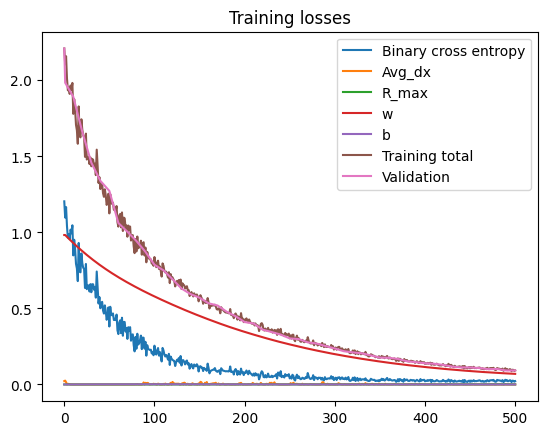

In [49]:
plot_losses(all_losses, val_loss_per_epoch, epochs_to_save)

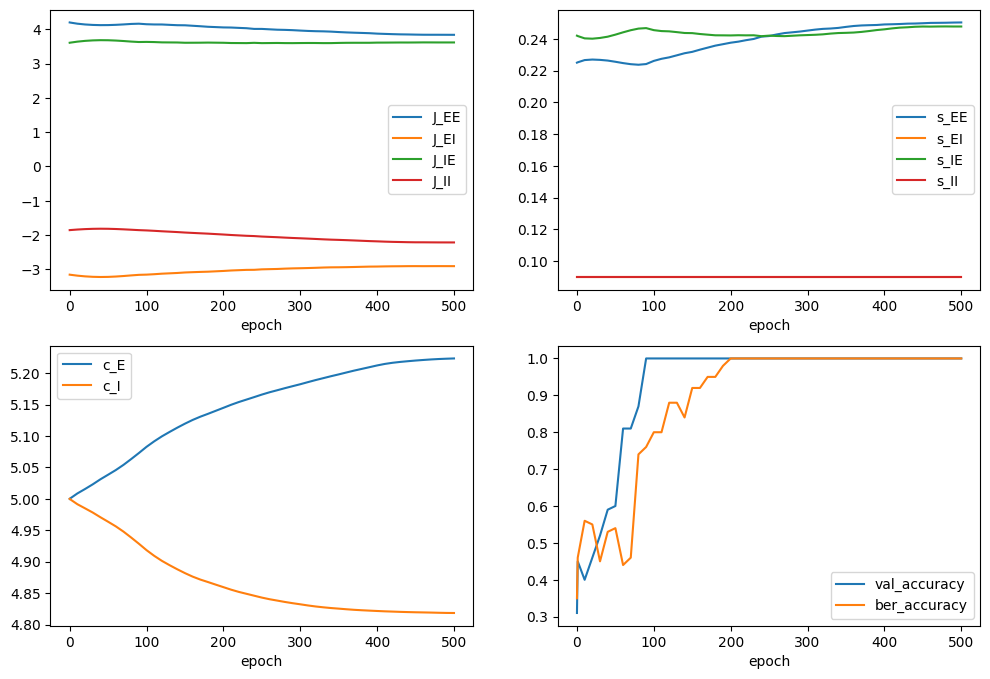

In [50]:
plot_results(results_filename)

In [51]:
param_ratios(results_filename)

Index(['J_EE', 'J_EI', 'J_IE', 'J_II'], dtype='object')
J ratios =  [-8 -7  0 19]
Index(['s_EE', 's_EI', 's_IE', 's_II'], dtype='object')
[1.1125652 1.0 1.0238617758734805 1.0]
s ratios =  [11  0  2  0]


In [59]:
train_data = create_data(stimuli_pars, number = 1, offset = offset, ref_ori = ref_ori)
    
J_2x2, s_2x2 = exponentiate(opt_pars)

#Initialise network
ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2, gE=gE, gI=gI, sigma_oris= opt_pars['sigma_oris'])

#Create vector using extrasynaptic constants
constant_vector = constant_to_vec(opt_pars['c_E'], opt_pars['c_I'])

#Apply Gabor filters to stimuli
output_ref=np.matmul(ssn.gabor_filters, train_data['ref'][0]) + constant_vector
output_target=np.matmul(ssn.gabor_filters, train_data['target'][0]) + constant_vector

#Rectify output
SSN_input_ref=np.maximum(0, output_ref)
SSN_input_target=np.maximum(0, output_target)

  
r_init = np.zeros(SSN_input_ref.shape[0])

dt = conv_pars.dt
xtol = conv_pars.xtol
Tmax = conv_pars.Tmax
verbose = conv_pars.verbose
silent = conv_pars.silent

if conv_pars.Rmax_E:
    Rmax_E = conv_pars.Rmax_E
    Rmax_I = conv_pars.Rmax_I

#Find fixed point
fp, _, avg_dx = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, dt=dt, xtol=xtol, Tmax=Tmax, verbose = verbose, silent=silent)
avg_dx = np.maximum(0, (avg_dx -1))

#Apply bounding box to data
x_box = ssn.apply_bounding_box(fp, size=3.2)

r_max = np.maximum(0, (our_max(fp[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp[ssn.Ne:-1])/Rmax_I - 1))

In [62]:
x_ref, _, _ = obtain_fixed_point(ssn, SSN_input_ref, conv_pars, inhibition = True)

2.9320538


In [64]:
x_ref[0].max()

DeviceArray(23.10794, dtype=float32)

In [25]:
sorted(fp[:ssn.Ne])

[DeviceArray(1.359313e-20, dtype=float32),
 DeviceArray(1.8174024e-20, dtype=float32),
 DeviceArray(5.069105e-19, dtype=float32),
 DeviceArray(8.444211e-19, dtype=float32),
 DeviceArray(9.512116e-19, dtype=float32),
 DeviceArray(1.5805414e-18, dtype=float32),
 DeviceArray(1.6125386e-18, dtype=float32),
 DeviceArray(5.3820887e-18, dtype=float32),
 DeviceArray(1.2200087e-17, dtype=float32),
 DeviceArray(1.4550056e-17, dtype=float32),
 DeviceArray(2.0194892e-17, dtype=float32),
 DeviceArray(2.1084703e-17, dtype=float32),
 DeviceArray(3.009216e-17, dtype=float32),
 DeviceArray(3.085361e-17, dtype=float32),
 DeviceArray(3.591249e-17, dtype=float32),
 DeviceArray(4.1010923e-17, dtype=float32),
 DeviceArray(7.166156e-17, dtype=float32),
 DeviceArray(2.5139911e-16, dtype=float32),
 DeviceArray(3.8294852e-16, dtype=float32),
 DeviceArray(6.251105e-16, dtype=float32),
 DeviceArray(8.855527e-16, dtype=float32),
 DeviceArray(1.465906e-15, dtype=float32),
 DeviceArray(2.1317193e-15, dtype=float32),

In [ ]:
#results = '/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/jitted_function/fixed_w_etadivide10.csv'
new_pars, val_loss_per_epoch, training_losses = train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars,  conv_pars, loss_pars, epochs_to_save = epochs_to_save, results_filename=results_filename, ref_ori = 55, offset = offset, batch_size = batch_size, epochs = epochs, bernoulli = True, sig_noise =sig_noise, eta=eta)

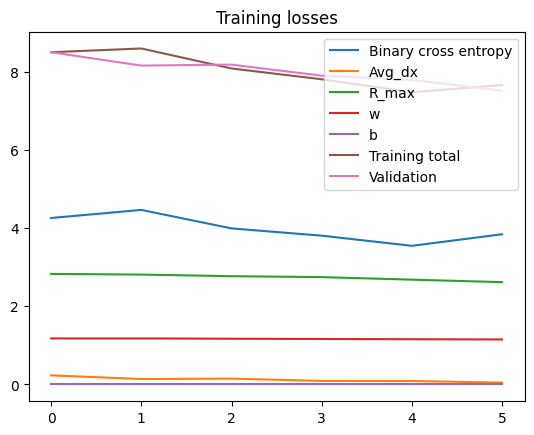

In [14]:
plot_losses(training_losses, val_loss_per_epoch, epochs_to_save)

In [ ]:
plot_results(results_filename, bernoulli = True)

In [ ]:
param_ratios(results_filename)


## Initialization histogram

In [ ]:
## PLOT INITIALIZATION HISTOGRAM
import numpy

def vmap_eval3(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars, conv_pars, loss_pars, bernoulli, sig_noise):
    '''
    Iterates through all values of 'w' to give the losses at each stimuli and weight, and the accuracy at each weight
    Output:
        losses: size(n_weights, n_stimuli )
        accuracy: size( n_weights)
    '''
    eval_vmap = vmap(vmap_eval, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': 0, 'c_E':None, 'c_I':None}, None, None, None,  {'ref':None, 'target':None, 'label':None}, None, None, None, None, None) )
    losses, true_acc, ber_acc = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise)

    return losses, true_acc, ber_acc


def test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, loss_pars, bernoulli, sig_noise, trials = 5, p = 0.9, printing=True):
    
    key = random.PRNGKey(7)
    N_neurons = 25
    accuracies = []
    key, _ = random.split(key)
    opt_pars['w_sig'] = random.normal(key, shape = (trials, N_neurons)) / np.sqrt(N_neurons)
    
    train_data = create_data(stimuli_pars, offset = 2)
    val_loss, true_acc, ber_acc = vmap_eval3(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars, conv_pars, loss_pars,  bernoulli, sig_noise)
    
    #calcualate how many accuracies are above 90
    higher_90 = np.sum(true_acc[true_acc>p]) / len(true_acc)
    
    if printing:
        print('grating contrast = {}, jitter = {}, noise std={}, acc (% >90 ) = {}'.format(stimuli_pars['grating_contrast'], stimuli_pars['jitter_val'], stimuli_pars['std'], higher_90))
    print(true_acc.shape)
    
    return higher_90, true_acc, opt_pars['w_sig']


def initial_acc( opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars,  loss_pars,  sig_noise , bernoulli = True, jitter_max = None, p = 0.9):
    '''
    Find initial accuracy for varying jitter and noise levels. 
    
    '''

    len_noise = 11
    len_jitters = 3
    #list_noise  = np.linspace(0, sig_noise, len_noise)
    #list_jitters = np.linspace(3, 5, len_jitters)
    list_noise  = np.linspace(2.5, 3, 3)
    list_jitters = np.linspace(5, 5, 3)
   
    
    low_acc=[]
    all_accuracies=[]
    percent_50=[]
    good_w_s=[]
    
    
    for sig_noise in list_noise:
        for jitter in list_jitters:
            
            #stimuli_pars['std'] = noise
            stimuli_pars['jitter_val'] = jitter
            higher_90, acc, w_s = test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars, conv_pars, stimuli_pars, loss_pars, bernoulli, sig_noise, p=p,  trials=100, printing=False)
            
            #save low accuracies
            if higher_90 < 0.05:
                low_acc.append([jitter, sig_noise, higher_90])
            
            indices = list(filter(lambda x: acc[x] == 0.5, range(len(acc))))
            w_s = [w_s[idx] for idx in indices]
            good_w_s.append(w_s)
            
            all_accuracies.append([jitter, sig_noise, acc])
            
    plot_histograms(all_accuracies)
        
    
    return all_accuracies, low_acc, percent_50, good_w_s


def plot_histograms(all_accuracies):
    
    n_rows =  int(np.sqrt(len(all_accuracies)))
    n_cols = int(np.ceil(len(all_accuracies) / n_rows))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 20))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    count = 0

    
   #plot histograms
    for k in range(n_rows):
        for j in range (n_cols):
            axs[k,j].hist(all_accuracies[count][2])
            axs[k,j].set_xlabel('Initial accuracy')
            axs[k,j].set_ylabel('Frequency')
            axs[k,j].set_title('std = '+str(np.round(all_accuracies[count][1], 2))+ ' jitter = '+str(np.round(all_accuracies[count][0], 2)), fontsize=10)
            count+=1
            if count==len(all_accuracies):
                break
    
    fig.show()

In [ ]:
all_acc, low_acc, percent_50, w = initial_acc( opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars,  loss_pars, bernoulli = True, sig_noise = 5)

In [ ]:
w[0]

In [ ]:
results_filename = '/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/jitted_function/fixed_weights_lambda2_trial2.csv'

In [ ]:
param_ratios(results_filename)

In [ ]:
plot_results(results_filename)